In [ ]:
#Load packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.pyplot import plot, show, savefig, xlim, figure, \
                ylim, legend, boxplot, setp, axes
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
# df1 = pd.read_csv("investments_VC1.csv", encoding='latin-1')
# df1.head()

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1PISHPLLV0Jb0MsbIqMTlXikIL6kscWRy' # The shareable link

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df1 = pd.read_csv('Filename.csv', encoding='latin-1')
# Dataset is now stored in a Pandas Dataframe

In [ ]:
# drop NA values for market

df1.dropna(subset=['market', 'status', 'founded_month', 'founded_year', 'country_code',
                  ' funding_total_usd ', 'founded_at', 'first_funding_at', 'last_funding_at', 'homepage_url'], how='any', axis=0, inplace = True)

# drop homepage_url, permalink, and category_list columns

df1 = df1.drop(['permalink', 'category_list'], axis = 1)


In [ ]:
# remove year (XXXX_) from founded_month and founded_quarter columns

df1['founded_month'] = df1['founded_month'].str[5:]
df1['founded_quarter'] = df1['founded_quarter'].str[5:]

In [ ]:
# change type of founded_at to datetime

#df1['founded_at'] = pd.to_datetime(df1['founded_at']) #turning dates into actual dates

# change type of money-based columns to numeric

df1['round_A'] = pd.to_numeric(df1['round_A'])
df1['round_B'] = pd.to_numeric(df1['round_B'])
df1['round_C'] = pd.to_numeric(df1['round_C'])
df1['round_D'] = pd.to_numeric(df1['round_D'])
df1['round_E'] = pd.to_numeric(df1['round_E'])
df1['round_F'] = pd.to_numeric(df1['round_F'])
df1['round_G'] = pd.to_numeric(df1['round_G'])
df1['round_H'] = pd.to_numeric(df1['round_H'])
df1['seed'] = pd.to_numeric(df1['seed'])
df1['venture'] = pd.to_numeric(df1['venture'])
df1['equity_crowdfunding'] = pd.to_numeric(df1['equity_crowdfunding'])
df1['undisclosed'] = pd.to_numeric(df1['undisclosed'])
df1['convertible_note'] = pd.to_numeric(df1['convertible_note'])
df1['debt_financing'] = pd.to_numeric(df1['debt_financing'])
df1['angel'] = pd.to_numeric(df1['angel'])
df1['private_equity'] = pd.to_numeric(df1['private_equity'])
df1['post_ipo_debt'] = pd.to_numeric(df1['post_ipo_debt'])
df1['post_ipo_equity'] = pd.to_numeric(df1['post_ipo_equity'])
df1['product_crowdfunding'] = pd.to_numeric(df1['product_crowdfunding'])
df1['secondary_market'] = pd.to_numeric(df1['secondary_market'])
df1 = df1.astype({'founded_year':'int'})

df1['founded_at'] = pd.to_datetime(df1['founded_at'])

df1['first_funding_at'] = pd.to_datetime(df1['first_funding_at'])

df1['age_first_funding'] = df1['first_funding_at'] - df1['founded_at']
df1['age_first_funding'] = df1['age_first_funding'].dt.days.astype('int16')
df1.age_first_funding = np.where(df1.age_first_funding < 0, 0, df1.age_first_funding)

In [ ]:



# total_investment column from all money-based numeric columns (aside from round X funding)

df1['total_investment'] = df1['seed'] + df1['venture'] +df1['equity_crowdfunding'] + df1['undisclosed'] + df1['convertible_note'] + df1['debt_financing'] + df1['angel'] + df1['grant'] + df1['private_equity'] + df1['post_ipo_equity'] + df1['post_ipo_debt'] + df1['secondary_market'] + df1['product_crowdfunding']

# remove funding_total_usd column; redundant

df1 = df1.drop([' funding_total_usd '], axis = 1)

#df1['total_investment'].describe()

Text(0, 0.5, 'total investment in USD')

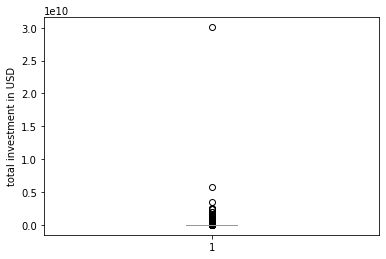

In [ ]:
plt.boxplot(df1['total_investment'])
plt.ylabel('total investment in USD')

In [ ]:
df1

,name,homepage_url,market,status,country_code,state_code,region,city,funding_rounds,founded_at,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,total_investment
0,#waywire,http://www.waywire.com,News,acquired,USA,NY,New York City,New York,1,2012-06-01,...,0,0,0,0,0,0,0,0,29,1750000
2,'Rock' Your Paper,http://www.rockyourpaper.org,Publishing,operating,EST,NaN,Tallinn,Tallinn,1,2012-10-26,...,0,0,0,0,0,0,0,0,0,40000
3,(In)Touch Network,http://www.InTouchNetwork.com,Electronics,operating,GBR,NaN,London,London,1,2011-04-01,...,0,0,0,0,0,0,0,0,0,1500000
8,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,...,0,0,0,0,0,0,0,0,1665,0
10,"1,2,3 Listo",http://www.123listo.com,E-Commerce,operating,CHL,NaN,Santiago,Las Condes,1,2012-01-01,...,0,0,0,0,0,0,0,0,414,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49420,Zyraz Technology,http://www.zyraz.com,Biotechnology,closed,MYS,NaN,MYS - Other,Damansara New Village,4,1994-01-01,...,7991547,0,0,0,0,0,0,0,5113,15419877
49422,Zytoprotec,http://www.zytoprotec.com,Biotechnology,operating,AUT,NaN,Vienna,Gerasdorf Bei Wien,1,2007-01-01,...,2686600,0,0,0,0,0,0,0,2220,2686600
49423,Zzish,http://www.zzish.com,Education,operating,GBR,NaN,London,London,1,2013-01-28,...,0,0,0,0,0,0,0,0,420,320000
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Web Development,operating,HRV,NaN,Split,Split,5,2012-05-13,...,0,0,0,0,0,0,0,0,0,97398


In [ ]:
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm')

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,total_investment
funding_rounds,1.000000,-0.058846,0.090767,0.413715,-0.001004,0.047523,0.012332,0.021179,0.078495,0.014701,0.064501,0.020471,-0.001113,0.026321,0.016249,0.185252,0.278973,0.303298,0.204182,0.214994,0.110184,0.064913,0.038251,-0.074562,0.114283
founded_year,-0.058846,1.000000,0.083853,-0.090870,0.000750,-0.030906,-0.010329,-0.027216,0.019715,-0.091967,-0.064103,-0.046011,-0.034065,-0.006170,-0.001352,-0.014334,-0.039750,-0.046072,-0.029570,-0.029644,-0.010124,-0.002967,-0.000655,-0.836031,-0.068442
seed,0.090767,0.083853,1.000000,-0.017096,-0.004232,-0.005232,-0.002123,-0.002867,-0.004456,-0.006404,-0.011135,-0.005380,-0.003925,-0.003067,0.268998,0.020334,-0.000273,-0.004917,-0.013475,-0.016656,-0.008269,-0.003272,-0.001738,-0.070402,-0.003333
venture,0.413715,-0.090870,-0.017096,1.000000,-0.008384,0.020275,0.000359,0.009162,0.003611,0.013088,0.071074,0.009506,-0.002527,0.112257,-0.003416,0.320962,0.503154,0.590420,0.612629,0.552288,0.448895,0.442103,0.394410,0.013761,0.210021
equity_crowdfunding,-0.001004,0.000750,-0.004232,-0.008384,1.000000,-0.001357,-0.000160,-0.000435,0.041498,-0.000996,-0.002175,-0.000693,-0.000498,-0.000413,0.012893,-0.005423,-0.006962,-0.005740,-0.002893,-0.002498,-0.001088,-0.000448,-0.000219,0.012710,-0.001520
undisclosed,0.047523,-0.030906,-0.005232,0.020275,-0.001357,1.000000,-0.000604,-0.000245,0.014791,-0.000950,0.018013,-0.000814,-0.000604,-0.000501,-0.000678,0.007079,0.002688,0.010243,0.002945,0.049568,-0.000681,-0.000387,-0.000266,0.021944,0.018931
convertible_note,0.012332,-0.010329,-0.002123,0.000359,-0.000160,-0.000604,1.000000,0.000969,-0.000931,-0.000352,0.007437,-0.000281,-0.000239,-0.000198,-0.000210,-0.001991,0.000218,0.001608,0.000370,-0.000085,-0.000430,-0.000120,-0.000105,0.014618,0.011784
debt_financing,0.021179,-0.027216,-0.002867,0.009162,-0.000435,-0.000245,0.000969,1.000000,-0.001437,-0.000292,0.008980,-0.000051,-0.000183,-0.000102,-0.000224,-0.000292,0.007453,0.008709,0.003734,0.006934,0.005502,0.000125,-0.000019,0.030068,0.933509
angel,0.078495,0.019715,-0.004456,0.003611,0.041498,0.014791,-0.000931,-0.001437,1.000000,-0.003474,0.004728,-0.002791,-0.002020,0.009314,-0.001826,0.023025,-0.002091,0.003653,0.013727,-0.001901,-0.003248,-0.000632,0.000484,-0.040518,0.002957
grant,0.014701,-0.091967,-0.006404,0.013088,-0.000996,-0.000950,-0.000352,-0.000292,-0.003474,1.000000,0.005716,0.001215,-0.000435,-0.000371,0.001188,0.003546,0.003750,0.012907,0.005848,0.015996,-0.000511,-0.000402,-0.000197,0.083821,0.031080


In [ ]:
#transform non-zero columns for rounds into 1
#keep 0's as 0's
#definitely not done with EDA

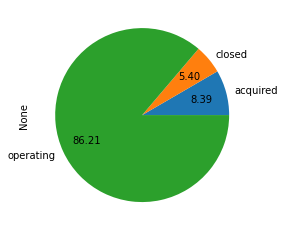

In [ ]:
# pie chart of status

df1.groupby('status').size().plot(kind='pie', autopct='%.2f', pctdistance=0.7)

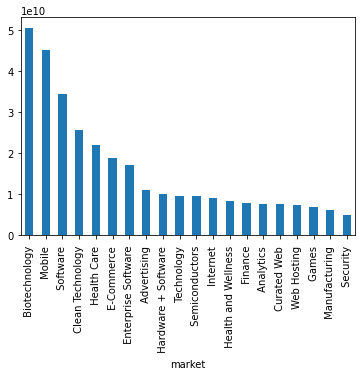

In [ ]:
# bar chart of total investment by market, top 20 shown

test = df1.groupby(['market']).sum()["total_investment"].sort_values(ascending=False)[:20]
test.plot.bar()

In [ ]:
test = df1.groupby(['market']).mean()["total_investment"].sort_values(ascending=False)[:5]
test

df1[df1["market"] == " Medical Professionals "]


,name,homepage_url,market,status,country_code,state_code,region,city,funding_rounds,founded_at,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,total_investment
8616,ClearChoice Holdings,http://www.clearchoice.com,Medical Professionals,operating,USA,CO,Denver,Greenwood Village,3,2005-01-01,...,0,0,0,0,0,0,0,0,1575,60829111
19634,i-Human Patients,http://www.i-human.com,Medical Professionals,operating,USA,CA,SF Bay Area,Sunnyvale,1,2012-01-01,...,0,0,0,0,0,0,0,0,360,2039305
21682,ITI Tech,http://www.illiti.com,Medical Professionals,operating,USA,IL,Chicago,Homewood,2,2000-02-02,...,100000,0,0,0,0,0,0,0,397,200000
28429,National Veterinary Associates,http://www.nvaonline.com,Medical Professionals,acquired,USA,CA,Los Angeles,Agoura Hills,1,1996-01-01,...,0,0,0,0,0,0,0,0,4138,128000000


In [ ]:
for col in df1.columns:
    print(col)

name
homepage_url
market
status
country_code
state_code
region
city
funding_rounds
founded_at
founded_month
founded_quarter
founded_year
first_funding_at
last_funding_at
seed
venture
equity_crowdfunding
undisclosed
convertible_note
debt_financing
angel
grant
private_equity
post_ipo_equity
post_ipo_debt
secondary_market
product_crowdfunding
round_A
round_B
round_C
round_D
round_E
round_F
round_G
round_H
age_first_funding
total_investment


Text(0.5, 1.0, 'Pre-seed VC funding')

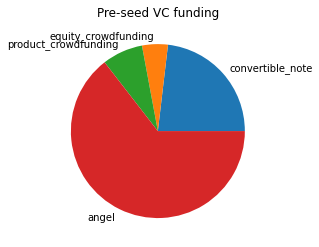

In [ ]:
# pre-seed pie chart

df1[["convertible_note", "equity_crowdfunding", "product_crowdfunding", "angel"]].sum().plot(kind="pie")
plt.ylabel(" ")
plt.title("Pre-seed VC funding")

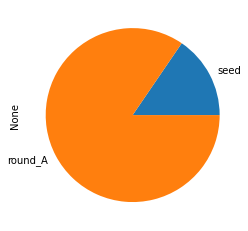

In [ ]:
# early-stage pie chart

df1[["seed", "round_A"]].sum().plot(kind="pie")

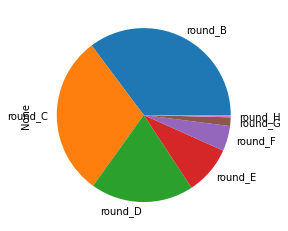

In [ ]:
# late-stage pie chart

df1[["round_B","round_C","round_D","round_E","round_F","round_G","round_H"]].sum().plot(kind="pie")

In [ ]:
# # early stage VC column comprised of seed and round A funding

df1["early_stage_VC"] = df1["seed"] + df1["round_A"]

# # pre-seed column comprised of debt financing, convertible note, equity crowdfunding, product crowdfunding, angel

df1["pre-seed"] = df1["convertible_note"] + df1["equity_crowdfunding"] + df1["product_crowdfunding"] + df1["angel"]

# # late-stage column comprised of round B, round C, round D, round E, round F, round G, and round H funding

df1["late_stage"] = df1["round_B"] + df1["round_C"] + df1["round_D"] + df1["round_E"] + df1["round_F"] + df1["round_G"] + df1["round_H"]

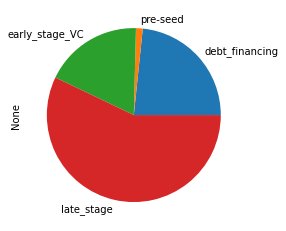

In [ ]:
# pie chart of debt financing, pre-seed, early stage, and late stage

df1[["debt_financing", "pre-seed", "early_stage_VC", "late_stage"]].sum().plot(kind="pie")

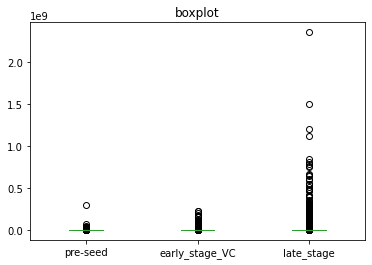

In [ ]:
# box plot of total funding for stages

# topmarkets = df1.groupby(['market']).sum()["total_investment"].sort_values(ascending=False)[:20].index.tolist()

# testing = df1[df1["market"].isin(topmarkets)]

# testing

# testing.plot(x="market", y=["pre-seed", "early_stage_VC", "late_stage"], kind="bar")

# ax = testing.plot(x="market", y="pre-seed", kind="bar")
# testing.plot(x="market", y="early_stage_VC", kind="bar", ax=ax, color="C2")
# testing.plot(x="market", y="late_stage", kind="bar", ax=ax, color="C3")

# plt.show()

ax = df1[['pre-seed', 'early_stage_VC', 'late_stage']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

In [ ]:
df1[df1["total_investment"] > 25000000000].squeeze()
df1 = df1[df1["name"] != "Verizon Communications"]

31525

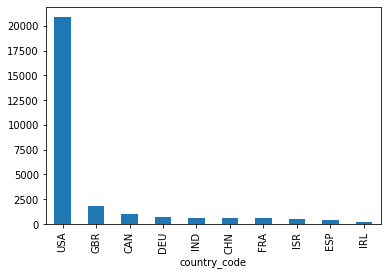

In [ ]:
# total amount of startups by country

test = df1.groupby(['country_code']).count()["total_investment"].sort_values(ascending=False)[:10]
test.plot.bar()
len(df1)

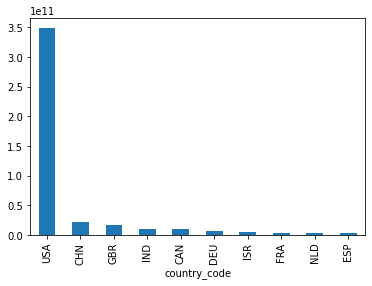

In [ ]:

# total investment $ by country

test = df1.groupby(['country_code']).sum()["total_investment"].sort_values(ascending=False)[:10]
test.plot.bar()

In [ ]:
# ending url feature and company name length feature

def func(string):
  return string.split('/')[2].split('.')[-1]

df1["url_end"] = df1["homepage_url"].apply(func)
df1["name_length"] = df1["name"].apply(len)


<ipython-input-24-259daa496aa4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["url_end"] = df1["homepage_url"].apply(func)
<ipython-input-24-259daa496aa4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["name_length"] = df1["name"].apply(len)


Text(0.5, 1.0, '# of companies by url ending, excluding .com')

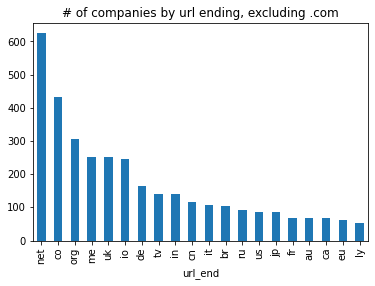

In [ ]:

# distribution of total companies by url endings (not including .com, which comprises 86% of companies in dataset)

testdf = df1[df1["url_end"] != "com"]
test = testdf.groupby(['url_end']).count()["total_investment"].sort_values(ascending=False)[:20]
test.plot.bar()
plt.title("# of companies by url ending, excluding .com")

Text(0.5, 1.0, 'Total investment (billions) by url ending')

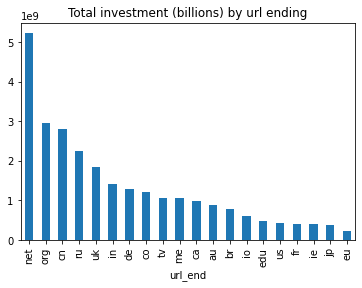

In [ ]:
# distribution of total companies by url endings (not including .com, which comprises 93.7% of total investment $ among all companies)

test = testdf.groupby(['url_end']).sum()["total_investment"].sort_values(ascending=False)[:20]
test.plot.bar()
plt.title("Total investment (billions) by url ending")

Text(0, 0.5, 'Total investment (tens of billions USD)')

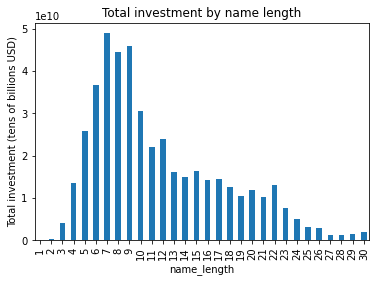

In [ ]:

# total investment $ by company name length
test = df1.groupby(['name_length']).sum()["total_investment"][:30]
test.plot.bar()
plt.title("Total investment by name length")
plt.ylabel("Total investment (tens of billions USD)")

Text(0, 0.5, '# of companies')

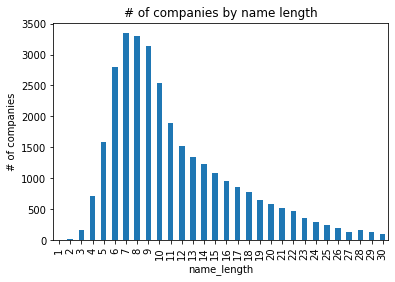

In [ ]:

# number of startups by company name length
test = df1.groupby(['name_length']).count()["total_investment"][:30]
test.plot.bar()
plt.title("# of companies by name length")
plt.ylabel("# of companies")

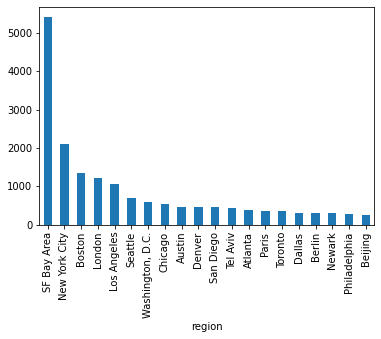

In [ ]:
# region vs number of companies

test = df1.groupby(['region']).count()["total_investment"].sort_values(ascending=False)[:20]
test.plot.bar()

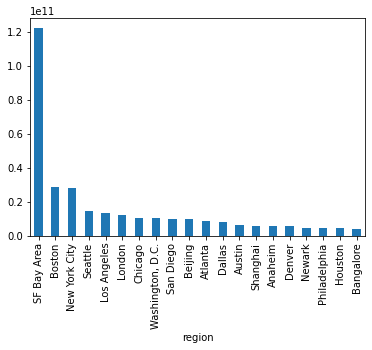

In [ ]:
# region vs total investment

test = df1.groupby(['region']).sum()["total_investment"].sort_values(ascending=False)[:20]
test.plot.bar()

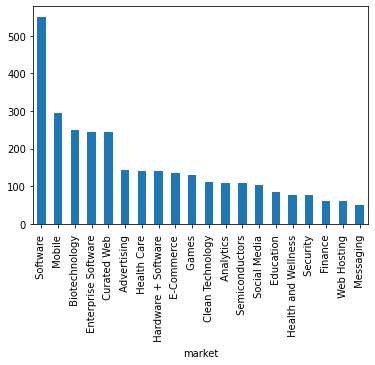

In [ ]:
# industry breakdown for specific regions with most companies (total investment) - maybe don't use

testing = df1[df1["region"] == "SF Bay Area"].groupby(['market']).count()["total_investment"].sort_values(ascending=False)[:20]
testing.plot.bar()

3.895321173671689

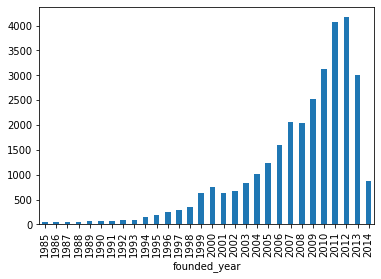

In [ ]:
# bar chart of total companies by year
testing = df1[df1["founded_year"] >= 1985].groupby(['founded_year']).count()["total_investment"]
testing.plot.bar()
#plt.locator_params(axis='x', nbins=25)

safe_rate = df1[df1["founded_year"] <= 1994].groupby(['founded_year']).count()["total_investment"].sum()
percent_removed = (safe_rate*100)/31525
percent_removed

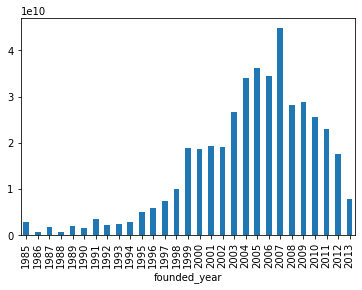

In [ ]:
# bar chart of total investment $ by year
testing = df1[(df1["founded_year"] >= 1985) & (df1["founded_year"] < 2014)].groupby(['founded_year']).sum()["total_investment"]
testing.plot.bar()

In [ ]:
df1["founded_year"]

0        2012
2        2012
3        2011
8        2010
10       2012
         ... 
49420    1994
49422    2007
49423    2013
49425    2012
49427    1999
Name: founded_year, Length: 31525, dtype: int64

In [ ]:
y = df1["status"]
X = df1.drop(["status", "name", "homepage_url"], axis=1)



In [ ]:
df3  = df1.drop(['early_stage_VC', 'pre-seed', 'late_stage'], axis = 1)
corr = df3.corr()
corr.style.background_gradient(cmap='coolwarm')

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,total_investment,name_length
funding_rounds,1.000000,-0.058638,0.090792,0.413764,-0.001002,0.047529,0.012334,0.068958,0.078510,0.014704,0.064510,0.020474,-0.001112,0.026324,0.016251,0.185284,0.279008,0.303332,0.204203,0.215015,0.110194,0.064919,0.038254,-0.074827,0.265290,-0.036461
founded_year,-0.058638,1.000000,0.083839,-0.090915,0.000746,-0.030915,-0.010332,-0.065747,0.019704,-0.091986,-0.064120,-0.046021,-0.034073,-0.006172,-0.001354,-0.014364,-0.039780,-0.046097,-0.029584,-0.029657,-0.010129,-0.002969,-0.000656,-0.835971,-0.132042,-0.158857
seed,0.090792,0.083839,1.000000,-0.017098,-0.004232,-0.005233,-0.002123,-0.010298,-0.004457,-0.006404,-0.011135,-0.005381,-0.003926,-0.003067,0.268999,0.020332,-0.000275,-0.004919,-0.013475,-0.016656,-0.008269,-0.003272,-0.001738,-0.070386,-0.005031,-0.045581
venture,0.413764,-0.090915,-0.017098,1.000000,-0.008384,0.020274,0.000358,0.079370,0.003610,0.013087,0.071074,0.009506,-0.002527,0.112257,-0.003416,0.320960,0.503153,0.590420,0.612629,0.552288,0.448896,0.442103,0.394410,0.013795,0.543342,-0.011136
equity_crowdfunding,-0.001002,0.000746,-0.004232,-0.008384,1.000000,-0.001357,-0.000160,-0.001845,0.041498,-0.000996,-0.002175,-0.000693,-0.000498,-0.000413,0.012893,-0.005423,-0.006962,-0.005740,-0.002893,-0.002498,-0.001088,-0.000448,-0.000219,0.012717,-0.003460,0.010466
undisclosed,0.047529,-0.030915,-0.005233,0.020274,-0.001357,1.000000,-0.000604,-0.000137,0.014791,-0.000950,0.018013,-0.000814,-0.000604,-0.000501,-0.000678,0.007079,0.002687,0.010243,0.002945,0.049568,-0.000681,-0.000387,-0.000266,0.021953,0.049186,0.013866
convertible_note,0.012334,-0.010332,-0.002123,0.000358,-0.000160,-0.000604,1.000000,0.007852,-0.000931,-0.000352,0.007437,-0.000281,-0.000239,-0.000198,-0.000210,-0.001991,0.000218,0.001608,0.000370,-0.000085,-0.000430,-0.000120,-0.000105,0.014623,0.030494,-0.001124
debt_financing,0.068958,-0.065747,-0.010298,0.079370,-0.001845,-0.000137,0.007852,1.000000,-0.005043,-0.000924,0.069317,0.000480,-0.000743,-0.000249,-0.000946,0.008699,0.064423,0.071718,0.031287,0.054541,0.042164,0.001483,0.000130,0.073369,0.395510,0.002731
angel,0.078510,0.019704,-0.004457,0.003610,0.041498,0.014791,-0.000931,-0.005043,1.000000,-0.003474,0.004728,-0.002791,-0.002020,0.009314,-0.001826,0.023024,-0.002092,0.003652,0.013726,-0.001901,-0.003249,-0.000632,0.000484,-0.040511,0.009407,-0.034544
grant,0.014704,-0.091986,-0.006404,0.013087,-0.000996,-0.000950,-0.000352,-0.000924,-0.003474,1.000000,0.005715,0.001215,-0.000435,-0.000371,0.001188,0.003546,0.003750,0.012907,0.005848,0.015996,-0.000511,-0.000402,-0.000197,0.083842,0.080265,0.023801


In [ ]:
#y = df1["status"]
#X = df1.drop(["status", "name", "homepage_url"], axis=1)
df1['statusNumbered'] = 0
for i in df1.index:
    if df1['status'][i] != 'closed':
        df1['statusNumbered'][i] = 1
df2 = df1.drop(['status'], axis = 1)
df2

#have to eliminate rows with year less than 1995
remove = df1[ (df1['founded_year'] <= 1995)  ].index
df1.drop(remove , inplace=True)


<ipython-input-37-defdb0b23fa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['statusNumbered'] = 0
<ipython-input-37-defdb0b23fa4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['statusNumbered'][i] = 1
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
mkts = df1.groupby(['market']).count()["total_investment"].sort_values(ascending=True)[:407]
mkts.sum()

1511

In [ ]:
top_20_markets = df1.groupby(['market']).count()["total_investment"].sort_values(ascending=False)[:20]
#To get the index values as a list/list of tuples for Index/MultiIndex do:
top_20_markets_list = top_20_markets.index.values.tolist()

top_15_countries = df1.groupby(['country_code']).count()["total_investment"].sort_values(ascending=False)[:15]

top_15_countries_list = top_15_countries.index.values.tolist()

top_15_countries_list

['USA',
 'GBR',
 'CAN',
 'DEU',
 'IND',
 'CHN',
 'FRA',
 'ISR',
 'ESP',
 'IRL',
 'AUS',
 'SGP',
 'NLD',
 'SWE',
 'ITA']

In [ ]:
for i in df1.index:
    if (df1['market'][i] not in top_20_markets_list):
      df1['market'][i] = ' Other '
    if (df1['country_code'][i] not in top_15_countries_list):
      df1['country_code'][i] = 'OTHER'
df1


<ipython-input-40-223cf4040d00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['market'][i] = ' Other '
<ipython-input-40-223cf4040d00>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['country_code'][i] = 'OTHER'


,name,homepage_url,market,status,country_code,state_code,region,city,funding_rounds,founded_at,...,round_G,round_H,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,url_end,name_length,statusNumbered
0,#waywire,http://www.waywire.com,Other,acquired,USA,NY,New York City,New York,1,2012-06-01,...,0,0,29,1750000,1750000,0,0,com,8,1
2,'Rock' Your Paper,http://www.rockyourpaper.org,Other,operating,OTHER,NaN,Tallinn,Tallinn,1,2012-10-26,...,0,0,0,40000,40000,0,0,org,17,1
3,(In)Touch Network,http://www.InTouchNetwork.com,Other,operating,GBR,NaN,London,London,1,2011-04-01,...,0,0,0,1500000,1500000,0,0,com,17,1
8,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,...,0,0,1665,0,0,0,0,de,16,1
10,"1,2,3 Listo",http://www.123listo.com,E-Commerce,operating,OTHER,NaN,Santiago,Las Condes,1,2012-01-01,...,0,0,414,40000,40000,0,0,com,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,4,1998-01-01,...,0,0,4411,34275015,0,0,12000000,com,6,1
49422,Zytoprotec,http://www.zytoprotec.com,Biotechnology,operating,OTHER,NaN,Vienna,Gerasdorf Bei Wien,1,2007-01-01,...,0,0,2220,2686600,2686600,0,0,com,10,1
49423,Zzish,http://www.zzish.com,Education,operating,GBR,NaN,London,London,1,2013-01-28,...,0,0,420,320000,320000,0,0,com,5,1
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Other,operating,OTHER,NaN,Split,Split,5,2012-05-13,...,0,0,0,97398,71525,25873,0,com,21,1


In [ ]:
count_other_country = df1[df1['country_code'] == 'OTHER'].groupby(['country_code']).count()['total_investment']
print(count_other_country)
count_other_market = df1[df1['market'] == ' Other '].groupby(['market']).count()['total_investment']
count_other_market


country_code
OTHER    2924
Name: total_investment, dtype: int64


market
 Other     12979
Name: total_investment, dtype: int64

In [ ]:
top_10_domain = df1.groupby(['url_end']).count()["total_investment"].sort_values(ascending=False)[:10]

top_10_domain_list = top_10_domain.index.values.tolist()


In [ ]:
for i in df1.index:
    if (df1['url_end'][i] not in top_10_domain):
      df1['url_end'][i] = 'other'
df1


<ipython-input-43-f9ae0136feb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['url_end'][i] = 'other'


,name,homepage_url,market,status,country_code,state_code,region,city,funding_rounds,founded_at,...,round_G,round_H,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,url_end,name_length,statusNumbered
0,#waywire,http://www.waywire.com,Other,acquired,USA,NY,New York City,New York,1,2012-06-01,...,0,0,29,1750000,1750000,0,0,com,8,1
2,'Rock' Your Paper,http://www.rockyourpaper.org,Other,operating,OTHER,NaN,Tallinn,Tallinn,1,2012-10-26,...,0,0,0,40000,40000,0,0,org,17,1
3,(In)Touch Network,http://www.InTouchNetwork.com,Other,operating,GBR,NaN,London,London,1,2011-04-01,...,0,0,0,1500000,1500000,0,0,com,17,1
8,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,...,0,0,1665,0,0,0,0,de,16,1
10,"1,2,3 Listo",http://www.123listo.com,E-Commerce,operating,OTHER,NaN,Santiago,Las Condes,1,2012-01-01,...,0,0,414,40000,40000,0,0,com,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,4,1998-01-01,...,0,0,4411,34275015,0,0,12000000,com,6,1
49422,Zytoprotec,http://www.zytoprotec.com,Biotechnology,operating,OTHER,NaN,Vienna,Gerasdorf Bei Wien,1,2007-01-01,...,0,0,2220,2686600,2686600,0,0,com,10,1
49423,Zzish,http://www.zzish.com,Education,operating,GBR,NaN,London,London,1,2013-01-28,...,0,0,420,320000,320000,0,0,com,5,1
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Other,operating,OTHER,NaN,Split,Split,5,2012-05-13,...,0,0,0,97398,71525,25873,0,com,21,1


In [ ]:
count_other_ur= df1[df1['url_end'] == 'other'].groupby(['url_end']).count()['total_investment']
count_other_ur

url_end
other    1726
Name: total_investment, dtype: int64

In [ ]:
test = df1
test3 = df1
# Get one hot encoding of columns market
one_hot_market = pd.get_dummies(test['market'])
# Drop column B as it is now encoded
test = test.drop('market',axis = 1)
# Join the encoded df
test = test.join(one_hot_market)
test

,name,homepage_url,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,Hardware + Software,Health Care,Health and Wellness,Manufacturing,Mobile,Other,Security,Semiconductors,Social Media,Software
0,#waywire,http://www.waywire.com,acquired,USA,NY,New York City,New York,1,2012-06-01,06,...,0,0,0,0,0,1,0,0,0,0
2,'Rock' Your Paper,http://www.rockyourpaper.org,operating,OTHER,NaN,Tallinn,Tallinn,1,2012-10-26,10,...,0,0,0,0,0,1,0,0,0,0
3,(In)Touch Network,http://www.InTouchNetwork.com,operating,GBR,NaN,London,London,1,2011-04-01,04,...,0,0,0,0,0,1,0,0,0,0
8,004 Technologies,http://004gmbh.de/en/004-interact,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,01,...,0,0,0,0,0,0,0,0,0,1
10,"1,2,3 Listo",http://www.123listo.com,operating,OTHER,NaN,Santiago,Las Condes,1,2012-01-01,01,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,ZYOMYX,http://www.zyomyx.com,operating,USA,MO,MO - Other,Fremont,4,1998-01-01,01,...,0,0,0,0,0,0,0,0,0,0
49422,Zytoprotec,http://www.zytoprotec.com,operating,OTHER,NaN,Vienna,Gerasdorf Bei Wien,1,2007-01-01,01,...,0,0,0,0,0,0,0,0,0,0
49423,Zzish,http://www.zzish.com,operating,GBR,NaN,London,London,1,2013-01-28,01,...,0,0,0,0,0,0,0,0,0,0
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,operating,OTHER,NaN,Split,Split,5,2012-05-13,05,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Get one hot encoding of columns url_end
one_hot_url = pd.get_dummies(test['url_end'])
# Drop column B as it is now encoded
test = test.drop('url_end',axis = 1)
# Join the encoded df
test = test.join(one_hot_url)

test

,name,homepage_url,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,com,de,in,io,me,net,org,other,tv,uk
0,#waywire,http://www.waywire.com,acquired,USA,NY,New York City,New York,1,2012-06-01,06,...,1,0,0,0,0,0,0,0,0,0
2,'Rock' Your Paper,http://www.rockyourpaper.org,operating,OTHER,NaN,Tallinn,Tallinn,1,2012-10-26,10,...,0,0,0,0,0,0,1,0,0,0
3,(In)Touch Network,http://www.InTouchNetwork.com,operating,GBR,NaN,London,London,1,2011-04-01,04,...,1,0,0,0,0,0,0,0,0,0
8,004 Technologies,http://004gmbh.de/en/004-interact,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,01,...,0,1,0,0,0,0,0,0,0,0
10,"1,2,3 Listo",http://www.123listo.com,operating,OTHER,NaN,Santiago,Las Condes,1,2012-01-01,01,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,ZYOMYX,http://www.zyomyx.com,operating,USA,MO,MO - Other,Fremont,4,1998-01-01,01,...,1,0,0,0,0,0,0,0,0,0
49422,Zytoprotec,http://www.zytoprotec.com,operating,OTHER,NaN,Vienna,Gerasdorf Bei Wien,1,2007-01-01,01,...,1,0,0,0,0,0,0,0,0,0
49423,Zzish,http://www.zzish.com,operating,GBR,NaN,London,London,1,2013-01-28,01,...,1,0,0,0,0,0,0,0,0,0
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,operating,OTHER,NaN,Split,Split,5,2012-05-13,05,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Get one hot encoding of columns url_end
one_hot_q = pd.get_dummies(test['founded_quarter'])
# Drop column B as it is now encoded
test = test.drop('founded_quarter',axis = 1)
# Join the encoded df
test = test.join(one_hot_q)




In [ ]:

#have to eliminate rows with year less than 1995
test_2 = test[ (test['founded_year'] <= 1995)  ].index
test.drop(test_2 , inplace=True)
test
test_4 = test3[(test3['founded_year'] <= 1995)].index
test3.drop(test_4, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
count_other_ur= test3[test3['url_end'] == 'other'].groupby(['url_end']).count()['total_investment']
print(count_other_ur)
count_other_country = test3[test3['country_code'] == 'OTHER'].groupby(['country_code']).count()['total_investment']
print(count_other_country)
count_other_market = test3[test3['market'] == ' Other '].groupby(['market']).count()['total_investment']
count_other_market

url_end
other    1726
Name: total_investment, dtype: int64
country_code
OTHER    2924
Name: total_investment, dtype: int64


market
 Other     12979
Name: total_investment, dtype: int64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
to_be_scaled = test

In [ ]:
to_be_scaled[['funding_rounds','founded_year','founded_month', 'age_first_funding']] = MinMaxScaler().fit_transform(to_be_scaled[['funding_rounds','founded_year','founded_month', 'age_first_funding']])
to_be_scaled

,name,homepage_url,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,me,net,org,other,tv,uk,Q1,Q2,Q3,Q4
0,#waywire,http://www.waywire.com,acquired,USA,NY,New York City,New York,0.000000,2012-06-01,0.454545,...,0,0,0,0,0,0,0,1,0,0
2,'Rock' Your Paper,http://www.rockyourpaper.org,operating,OTHER,NaN,Tallinn,Tallinn,0.000000,2012-10-26,0.818182,...,0,0,1,0,0,0,0,0,0,1
3,(In)Touch Network,http://www.InTouchNetwork.com,operating,GBR,NaN,London,London,0.000000,2011-04-01,0.272727,...,0,0,0,0,0,0,0,1,0,0
8,004 Technologies,http://004gmbh.de/en/004-interact,operating,USA,IL,"Springfield, Illinois",Champaign,0.000000,2010-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
10,"1,2,3 Listo",http://www.123listo.com,operating,OTHER,NaN,Santiago,Las Condes,0.000000,2012-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,ZYOMYX,http://www.zyomyx.com,operating,USA,MO,MO - Other,Fremont,0.176471,1998-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
49422,Zytoprotec,http://www.zytoprotec.com,operating,OTHER,NaN,Vienna,Gerasdorf Bei Wien,0.000000,2007-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
49423,Zzish,http://www.zzish.com,operating,GBR,NaN,London,London,0.000000,2013-01-28,0.000000,...,0,0,0,0,0,0,1,0,0,0
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,operating,OTHER,NaN,Split,Split,0.235294,2012-05-13,0.363636,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
scale_dollars = to_be_scaled
scale_dollars[['early_stage_VC','pre-seed','late_stage', 'total_investment', 'name_length', 'debt_financing']] = MinMaxScaler().fit_transform(scale_dollars[['early_stage_VC','pre-seed','late_stage', 'total_investment', 'name_length', 'debt_financing']])
scale_dollars

,name,homepage_url,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,me,net,org,other,tv,uk,Q1,Q2,Q3,Q4
0,#waywire,http://www.waywire.com,acquired,USA,NY,New York City,New York,0.000000,2012-06-01,0.454545,...,0,0,0,0,0,0,0,1,0,0
2,'Rock' Your Paper,http://www.rockyourpaper.org,operating,OTHER,NaN,Tallinn,Tallinn,0.000000,2012-10-26,0.818182,...,0,0,1,0,0,0,0,0,0,1
3,(In)Touch Network,http://www.InTouchNetwork.com,operating,GBR,NaN,London,London,0.000000,2011-04-01,0.272727,...,0,0,0,0,0,0,0,1,0,0
8,004 Technologies,http://004gmbh.de/en/004-interact,operating,USA,IL,"Springfield, Illinois",Champaign,0.000000,2010-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
10,"1,2,3 Listo",http://www.123listo.com,operating,OTHER,NaN,Santiago,Las Condes,0.000000,2012-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,ZYOMYX,http://www.zyomyx.com,operating,USA,MO,MO - Other,Fremont,0.176471,1998-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
49422,Zytoprotec,http://www.zytoprotec.com,operating,OTHER,NaN,Vienna,Gerasdorf Bei Wien,0.000000,2007-01-01,0.000000,...,0,0,0,0,0,0,1,0,0,0
49423,Zzish,http://www.zzish.com,operating,GBR,NaN,London,London,0.000000,2013-01-28,0.000000,...,0,0,0,0,0,0,1,0,0,0
49425,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,operating,OTHER,NaN,Split,Split,0.235294,2012-05-13,0.363636,...,0,0,0,0,0,0,0,1,0,0


In [ ]:

drop_them_col = scale_dollars
drop_them_col = drop_them_col.drop(columns = ['name', 'homepage_url', 'status', 'city', 'country_code', 'state_code', 'region', 'founded_at', 'first_funding_at',
                                    'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'angel', 'grant', 'private_equity',
                                    'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D',
                                    'round_E', 'round_F', 'round_G', 'round_H'])
ready = drop_them_col
ready.columns

Index(['funding_rounds', 'founded_month', 'founded_year', 'debt_financing',
       'age_first_funding', 'total_investment', 'early_stage_VC', 'pre-seed',
       'late_stage', 'name_length', 'statusNumbered', ' Advertising ',
       ' Analytics ', ' Biotechnology ', ' Clean Technology ', ' Consulting ',
       ' Curated Web ', ' E-Commerce ', ' Education ', ' Enterprise Software ',
       ' Finance ', ' Games ', ' Hardware + Software ', ' Health Care ',
       ' Health and Wellness ', ' Manufacturing ', ' Mobile ', ' Other ',
       ' Security ', ' Semiconductors ', ' Social Media ', ' Software ', 'co',
       'com', 'de', 'in', 'io', 'me', 'net', 'org', 'other', 'tv', 'uk', 'Q1',
       'Q2', 'Q3', 'Q4'],
      dtype='object')

In [ ]:
#Partition the data into 80% training and 20% testing
#There are many ways to do this!

#Here's an old school way that lets us separate the X and Y later 
np.random.seed(1) #Pick X_train = dfTrain.drop(['statusNumbered', 'name', 'homepage_url', 'url_end', 'market', 'country_code', 'state_code', 'region', 'city', 'founded_at', 'first_funding_at','last_funding_at', 'founded_quarter', 'round_A', 'seed', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'product_crowdfunding', 'convertible_note', 'angel'],axis=1)a random seed
mask = np.random.rand(len(ready)) < 0.8  #Generate an array of uniform random numbers between 0 and 1 and convert to 1 if < 0.8 (0 otherwise)

dfTrain = ready[mask] #Training data
dfTest = ready[~mask] #Testing data

y_train = dfTrain['statusNumbered']
X_train = dfTrain.drop(['statusNumbered'], axis = 1)
y_test = dfTest['statusNumbered']
X_test = dfTest.drop(['statusNumbered'], axis = 1)

In [ ]:
#Train a regularized logistic regression model using grid search using liblinear solver

#Define model parameters to search over
params = {'C':[0.001,0.01,0.1,1,10,100,500,1000],'penalty':['l1', 'l2']}

#Define model
model = LogisticRegression(solver='liblinear', max_iter = 10000)

#Define gridsearch - how many CVs (10) and what your scoring method will be (AUC) 
clf = GridSearchCV(model,params, cv=10,scoring='roc_auc')

#Run the gridsearch
clf.fit(X_train,y_train)

#Print results
clf.cv_results_

{'mean_fit_time': array([0.06414158, 0.07237079, 0.12414749, 0.08532889, 0.17195935,
        0.11148093, 0.6401123 , 0.15144923, 2.58826563, 0.19273407,
        0.7642416 , 0.25394969, 0.25388844, 0.32170389, 0.24565983,
        0.33104458]),
 'std_fit_time': array([0.0075022 , 0.00287966, 0.00956567, 0.00494285, 0.00584517,
        0.00498227, 0.12433971, 0.00704221, 1.03988263, 0.00656045,
        0.56641849, 0.01362208, 0.01911346, 0.02182813, 0.03385183,
        0.02009397]),
 'mean_score_time': array([0.0059932 , 0.0059737 , 0.00554192, 0.00636146, 0.00612652,
        0.0058722 , 0.00593853, 0.00597348, 0.00679095, 0.0056222 ,
        0.0058398 , 0.00608721, 0.00609426, 0.0060914 , 0.00519691,
        0.00587797]),
 'std_score_time': array([0.00102717, 0.00029137, 0.00118774, 0.00109499, 0.00129178,
        0.00045942, 0.00058902, 0.0010623 , 0.00166071, 0.00062827,
        0.00058147, 0.00136208, 0.0007655 , 0.00066009, 0.00017983,
        0.00052105]),
 'param_C': masked_array(d

In [ ]:
clf.best_estimator_.coef_

array([[ 6.27867262,  0.        ,  3.7268581 ,  0.        ,  6.17977308,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.21106597,  0.        ,  0.        ,  0.        ,
        -0.70335096,  0.        ,  0.03018796,  0.08360138,  0.        ,
        -0.36290711,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.36116204,  0.02788796,  0.        ,  0.        , -0.34978599,
         0.        ,  0.        , -0.05507627,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.03028231, -0.11794468,
         0.03364912]])

In [ ]:
#Pick the best model
print(clf.best_estimator_) 

#Print results
print(np.mean(clf.cv_results_['mean_test_score'])) #mean CV AUC
print(np.min(clf.cv_results_['mean_test_score'])) #min CV AUC
print(np.max(clf.cv_results_['mean_test_score'])) #max CV AUC

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')
0.7429417548823707
0.5
0.7996328473479253


In [ ]:
#Use the best model to make predictions
preds = clf.best_estimator_.predict_proba(X_test).T[1]
preds

array([0.95260507, 0.96485674, 0.94225732, ..., 0.95736804, 0.98935757,
       0.98672497])

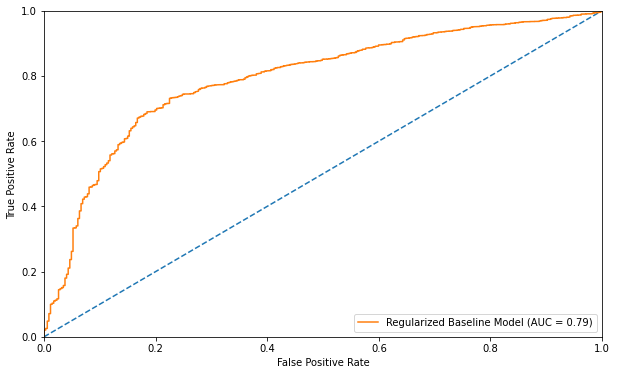

In [ ]:
#Create the ROC curve and compare with Q/D models

#ROC curve for regularized model
fprLR, tprLR, threshLR = roc_curve(y_test, preds)
roc_auc_LR= roc_auc_score(y_test, preds)

#Plot them all!
fig = figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprLR, tprLR, label='Regularized Baseline Model (AUC = %0.2f)' % roc_auc_LR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()
#fig.savefig('QvsDvsLR_ModelROC.pdf', bbox_inches='tight')

In [ ]:
#QUESTION 2 - b)
#Round the output using a threshold corresponding to a TPR of 0.85 for L1
yhatLRround = []

LOneRthresh = threshLR[next(x[0] for x in enumerate(tprLR) if x[1] > 0.85)]

for i in preds:
    if i > LOneRthresh:
        yhatLRround.append(1)
    else:
        yhatLRround.append(0)

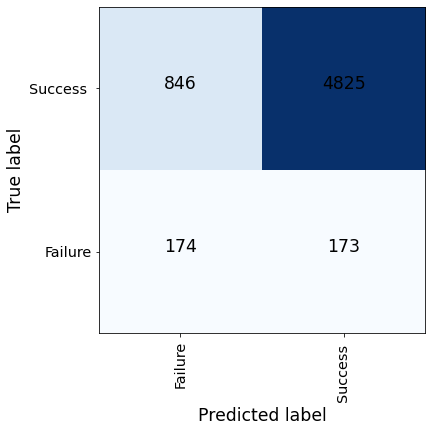

In [ ]:
cMatrix = confusion_matrix(y_true = y_test, y_pred = yhatLRround)
fig = figure(figsize=(10, 6))
plt.imshow(cMatrix, cmap=plt.cm.Blues)
plt.text(0, 0, '{}'.format(cMatrix[0, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(0, 1, '{}'.format(cMatrix[1, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 0, '{}'.format(cMatrix[0, 1]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 1, '{}'.format(cMatrix[1, 1]), horizontalalignment='center',fontsize = 'xx-large')
tick_marks = [0,1]
plt.ylim([-0.5,1.5])
labels = ['Failure', 'Success ']
plt.xticks(tick_marks, labels, rotation=90,fontsize = 'x-large')
plt.yticks(tick_marks, labels,fontsize = 'x-large')
plt.ylabel('True label',fontsize = 'xx-large')
plt.xlabel('Predicted label',fontsize = 'xx-large')
plt.show()
fig.savefig('LR_CM.pdf', bbox_inches='tight')

In [ ]:
startups_layoff = df2.loc[df2['founded_year'].between(2007, 2009)]
total = 0
success = 0
total_funding = 0
for i in startups_layoff.index:
  success += startups_layoff['statusNumbered'][i]
  total += 1
  total_funding += startups_layoff['total_investment'][i]
print(success/total)
print(total)
print(total_funding/total)
startups_layoff_failed = startups_layoff.loc[startups_layoff['statusNumbered'] == 0]
startups_layoff_failed

0.908446455505279
6630
15348229.305128206


,name,homepage_url,market,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,round_G,round_H,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,url_end,name_length,statusNumbered
30,10BestThings,http://10bestthings.com,Curated Web,USA,OH,Cleveland,Cleveland,1,2009-04-01,04,...,0,0,0,50000,50000,0,0,com,12,0
73,1DayMakeover,http://www.1daymakeover.com,E-Commerce,USA,CA,"Orange County, California",Santa Ana,1,2008-06-30,06,...,0,0,0,50000,50000,0,0,com,12,0
444,9car Technology LLC,http://www.chejianghu.com,Automotive,CHN,NaN,Beijing,Beijing,2,2009-11-18,11,...,0,0,0,80000,80000,0,0,com,19,0
503,Aarden Pharmaceuticals,http://aardenpharma.com,Biotechnology,USA,IN,Indianapolis,Indianapolis,1,2008-01-01,01,...,0,0,1098,500000,0,0,0,com,22,0
536,ABC Live,http://abclive.in,Advertising,IND,NaN,Chandigarh,Chandigarh,1,2007-12-05,12,...,0,0,0,25000,0,0,0,in,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49182,Zipano,http://www.zipano.com,Security,USA,PA,Pittsburgh,Pittsburgh,1,2009-06-01,06,...,0,0,30,25000,25000,0,0,com,6,0
49185,zipcodemailer.com,http://www.zipcodemailer.com,Postal and Courier Services,USA,AZ,Phoenix,Peoria,1,2008-10-11,10,...,0,0,0,15000,0,0,0,com,17,0
49212,Zipzoom,http://www.zipzoom.com/en/home2,E-Commerce,CAN,ON,Toronto,Toronto,1,2007-01-01,01,...,0,0,1502,2200000,0,2200000,0,com,7,0
49274,Zoodak,http://zoodak.com,Finance,USA,CA,SF Bay Area,San Ramon,1,2008-04-01,04,...,0,0,487,580000,580000,0,0,com,6,0


In [ ]:
total_all = 0
success_all = 0
total_funding_all = 0
for i in df2.index:
  success_all += df2['statusNumbered'][i]
  total_all += 1
  total_funding_all += df2['total_investment'][i]

print(total_all)
print(success_all/total_all)
print(total_funding_all/total_all)

31525
0.946011102299762
14541828.927613005


In [ ]:
startups_post_layoff = df2.loc[df2['founded_year'].between(2009, 2011)]
total = 0
success = 0
total_funding = 0
for i in startups_post_layoff.index:
  success += startups_post_layoff['statusNumbered'][i]
  total += 1
  total_funding += startups_post_layoff['total_investment'][i]
print(success/total)
print(total)
print(total_funding/total)
startups_post_layoff_failed = startups_post_layoff.loc[startups_post_layoff['statusNumbered'] == 0]
startups_post_layoff_failed

0.934668721109399
9735
7940864.975552131


,name,homepage_url,market,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,round_G,round_H,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,url_end,name_length,statusNumbered
30,10BestThings,http://10bestthings.com,Curated Web,USA,OH,Cleveland,Cleveland,1,2009-04-01,04,...,0,0,0,50000,50000,0,0,com,12,0
122,24PageBooks,http://24pagebooks.com,Software,USA,NY,"Rochester, New York",Rochester,1,2010-01-01,01,...,0,0,508,50000,50000,0,0,com,11,0
197,3ClickEMR Corporation,http://www.3clickemr.com,Electronic Health Records,USA,MA,Boston,West Roxbury,2,2010-06-23,06,...,0,0,0,500000,250000,250000,0,com,21,0
204,3D FUTURE VISION II,http://www.3dfuturevision.com,Games,USA,FL,Orlando,Longwood,2,2011-01-01,01,...,0,0,172,503000,0,0,0,com,19,0
379,77 Pieces,http://www.77-pieces.com,Curated Web,NZL,NaN,Wellington,Wellington,1,2010-05-25,05,...,0,0,280,650000,650000,0,0,com,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49158,Zin.gl,http://zin.gl,Curated Web,RUS,NaN,Moscow,Moscow,3,2011-02-01,02,...,0,0,0,1100000,950000,150000,0,gl,6,0
49182,Zipano,http://www.zipano.com,Security,USA,PA,Pittsburgh,Pittsburgh,1,2009-06-01,06,...,0,0,30,25000,25000,0,0,com,6,0
49366,ZummZumm,http://www.zummzumm.com,Social Media,GBR,NaN,London,London,1,2011-11-06,11,...,0,0,198,50000,50000,0,0,com,8,0
49384,Zuujit,http://www.zuujit.com,E-Commerce,USA,CA,Santa Barbara,Santa Barbara,1,2010-01-01,01,...,0,0,119,2700000,0,2700000,0,com,6,0


In [ ]:
startups_vpost_layoff = df2.loc[df2['founded_year'].between(2011, 2013)]
total = 0
success = 0
total_funding = 0
for i in startups_vpost_layoff.index:
  success += startups_vpost_layoff['statusNumbered'][i]
  total += 1
  total_funding += startups_vpost_layoff['total_investment'][i]
print(success/total)
print(total)
print(total_funding/total)
startups_vpost_layoff_failed = startups_vpost_layoff.loc[startups_vpost_layoff['statusNumbered'] == 0]
startups_vpost_layoff_failed

0.9725954266393807
11239
4291880.969837174


,name,homepage_url,market,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,...,round_G,round_H,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,url_end,name_length,statusNumbered
130,27 Perry,http://www.27perry.com,E-Commerce,USA,CO,Denver,Boulder,1,2012-07-25,07,...,0,0,0,118000,118000,0,0,com,8,0
204,3D FUTURE VISION II,http://www.3dfuturevision.com,Games,USA,FL,Orlando,Longwood,2,2011-01-01,01,...,0,0,172,503000,0,0,0,com,19,0
447,9facts,http://9facts.com,SEO,RUS,NaN,Perm,Yekaterinburg,1,2011-05-01,05,...,0,0,0,70000,70000,0,0,com,6,0
1003,AddFleet,http://www.addfleet.com,Mobile,ESP,NaN,Barcelona,Barcelona,2,2012-01-01,01,...,0,0,262,4160600,3900600,260000,0,com,8,0
1054,Adhere2Care,http://adhere2care.com,Health and Wellness,USA,GA,Atlanta,Peachtree City,1,2011-01-01,01,...,0,0,453,300000,0,0,0,com,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48528,Yibailin,http://www.yibailin.com,Mobile,CHN,NaN,Nanjing,Nanjing,1,2011-06-18,06,...,0,0,0,60000,60000,0,0,com,8,0
48562,Yobble,http://iphoneairguitar.com,iPhone,USA,CA,SF Bay Area,San Francisco,1,2011-01-18,01,...,0,0,134,0,0,0,0,com,6,0
48782,YUPIQ,http://yupiq.com,Music,CAN,BC,Vancouver,Victoria,1,2011-03-01,03,...,0,0,178,0,0,0,0,com,5,0
49158,Zin.gl,http://zin.gl,Curated Web,RUS,NaN,Moscow,Moscow,3,2011-02-01,02,...,0,0,0,1100000,950000,150000,0,gl,6,0


In [ ]:

ready_nondollar = ready.drop(columns = ['pre-seed', 'early_stage_VC', "debt_financing", "late_stage", "total_investment"], axis = 1) #
#Partition the data into 80% training and 20% testing
#There are many ways to do this!

#Here's an old school way that lets us separate the X and Y later 
np.random.seed(1) #Pick X_train = dfTrain.drop(['statusNumbered', 'name', 'homepage_url', 'url_end', 'market', 'country_code', 'state_code', 'region', 'city', 'founded_at', 'first_funding_at','last_funding_at', 'founded_quarter', 'round_A', 'seed', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'product_crowdfunding', 'convertible_note', 'angel'],axis=1)a random seed
mask = np.random.rand(len(ready_nondollar)) < 0.8 #Generate an array of uniform random numbers between 0 and 1 and convert to 1 if < 0.8 (0 otherwise)

dfTrain = ready_nondollar[mask] #Training data
dfTest = ready_nondollar[~mask] #Testing data

y_train = dfTrain['statusNumbered']
X_train = dfTrain.drop(['statusNumbered'], axis = 1)
y_test = dfTest['statusNumbered']
X_test = dfTest.drop(['statusNumbered'], axis = 1)

#Train a regularized logistic regression model using grid search using liblinear solver

#Define model parameters to search over
params = {'C':[0.001,0.01,0.1,1,10,100,500,1000],'penalty':['l1', 'l2']}

#Define model
model = LogisticRegression(solver='liblinear', max_iter = 10000)

#Define gridsearch - how many CVs (10) and what your scoring method will be (AUC) 
clf = GridSearchCV(model,params, cv=10,scoring='roc_auc')

#Run the gridsearch
clf.fit(X_train,y_train)

#Print results
#Use the best model to make predictions
preds_two = clf.best_estimator_.predict_proba(X_test).T[1]

#Pick the best model
print(clf.best_estimator_) 

preds_two

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')


array([0.9526121 , 0.96485537, 0.94225484, ..., 0.95737981, 0.98936144,
       0.9867266 ])

In [ ]:
ready_nondollar

,funding_rounds,founded_month,founded_year,age_first_funding,name_length,statusNumbered,Advertising,Analytics,Biotechnology,Clean Technology,...,me,net,org,other,tv,uk,Q1,Q2,Q3,Q4
0,0.000000,0.454545,0.888889,0.004238,0.122807,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.000000,0.818182,0.888889,0.000000,0.280702,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.000000,0.272727,0.833333,0.000000,0.280702,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0.000000,0.000000,0.777778,0.243314,0.263158,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,0.000000,0.000000,0.888889,0.060500,0.175439,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,0.176471,0.000000,0.111111,0.644600,0.087719,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
49422,0.000000,0.000000,0.611111,0.324419,0.157895,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
49423,0.000000,0.000000,0.944444,0.061377,0.070175,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49425,0.235294,0.363636,0.888889,0.000000,0.350877,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


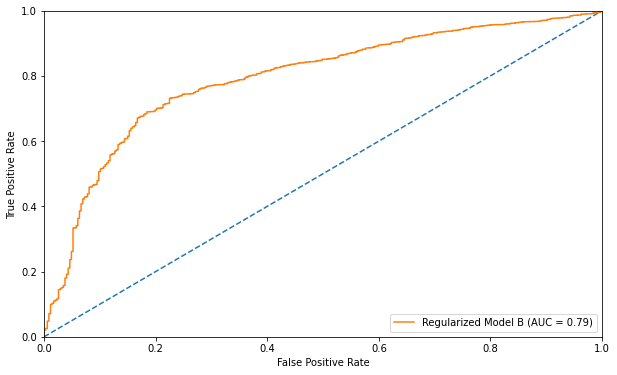

In [ ]:
#Create the ROC curve and compare with Q/D models

#ROC curve for regularized model
fprLR2, tprLR2, threshLR2 = roc_curve(y_test, preds_two)
roc_auc_LR2= roc_auc_score(y_test, preds_two)

#Plot them all!
fig = figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprLR2, tprLR2, label='Regularized Model B (AUC = %0.2f)' % roc_auc_LR2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()
#fig.savefig('QvsDvsLR_ModelROC.pdf', bbox_inches='tight')

In [ ]:
#Pick the best model
print(clf.best_estimator_) 

#Print results
print(np.mean(clf.cv_results_['mean_test_score'])) #mean CV AUC
print(np.min(clf.cv_results_['mean_test_score'])) #min CV AUC
print(np.max(clf.cv_results_['mean_test_score'])) #max CV AUC

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')
0.7426013038560659
0.5
0.7996275540411965


In [ ]:
ready_four = scale_dollars #initial model - founded year
ready_four = scale_dollars.drop(columns = ['name', 'homepage_url', 'status', 'country_code', 'state_code', 'region', 'founded_at', 'first_funding_at',
                                    'last_funding_at','venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'angel', 'grant', 'private_equity',
                                    'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_B', 'round_C', 'round_D',
                                    'round_E', 'round_F', 'round_G', 'round_H', 'city', 'seed', 'round_A', 'name_length', 'founded_year'])

ready_four

,funding_rounds,founded_month,debt_financing,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,statusNumbered,Advertising,...,me,net,org,other,tv,uk,Q1,Q2,Q3,Q4
0,0.000000,0.454545,0.000000,0.004238,0.000307,0.007778,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.000000,0.818182,0.000000,0.000000,0.000007,0.000178,0.000000,0.000000,1,0,...,0,0,1,0,0,0,0,0,0,1
3,0.000000,0.272727,0.000000,0.000000,0.000263,0.006667,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,1,0,0
8,0.000000,0.000000,0.000000,0.243314,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,1,0,0,0
10,0.000000,0.000000,0.000000,0.060500,0.000007,0.000178,0.000000,0.000000,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,0.176471,0.000000,0.000000,0.644600,0.006013,0.000000,0.000000,0.005106,1,0,...,0,0,0,0,0,0,1,0,0,0
49422,0.000000,0.000000,0.000000,0.324419,0.000471,0.011940,0.000000,0.000000,1,0,...,0,0,0,0,0,0,1,0,0,0
49423,0.000000,0.000000,0.000000,0.061377,0.000056,0.001422,0.000000,0.000000,1,0,...,0,0,0,0,0,0,1,0,0,0
49425,0.235294,0.363636,0.000000,0.000000,0.000017,0.000318,0.000359,0.000000,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:


#Here's an old school way that lets us separate the X and Y later 
np.random.seed(1) #Pick X_train = dfTrain.drop(['statusNumbered', 'name', 'homepage_url', 'url_end', 'market', 'country_code', 'state_code', 'region', 'city', 'founded_at', 'first_funding_at','last_funding_at', 'founded_quarter', 'round_A', 'seed', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'product_crowdfunding', 'convertible_note', 'angel'],axis=1)a random seed
mask = np.random.rand(len(ready_four)) < 0.8 #Generate an array of uniform random numbers between 0 and 1 and convert to 1 if < 0.8 (0 otherwise)

dfTrain = ready_four[mask] #Training data
dfTest = ready_four[~mask] #Testing data

y_train = dfTrain['statusNumbered']
X_train = dfTrain.drop(['statusNumbered'], axis = 1)
y_test = dfTest['statusNumbered']
X_test = dfTest.drop(['statusNumbered'], axis = 1)

#Train a regularized logistic regression model using grid search using liblinear solver

#Define model parameters to search over
params = {'C':[0.001,0.01,0.1,1,10,100,500,1000],'penalty':['l1', 'l2']}

#Define model
model = LogisticRegression(solver='liblinear', max_iter = 10000)

#Define gridsearch - how many CVs (10) and what your scoring method will be (AUC) 
clf = GridSearchCV(model,params, cv=10,scoring='roc_auc')

#Run the gridsearch
clf.fit(X_train,y_train)

#Print results
#Use the best model to make predictions
preds_three = clf.best_estimator_.predict_proba(X_test).T[1]
print(clf.best_estimator_)
preds_three

LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='liblinear')


array([0.97606383, 0.9332269 , 0.90444706, ..., 0.98427576, 0.99388774,
       0.99469922])

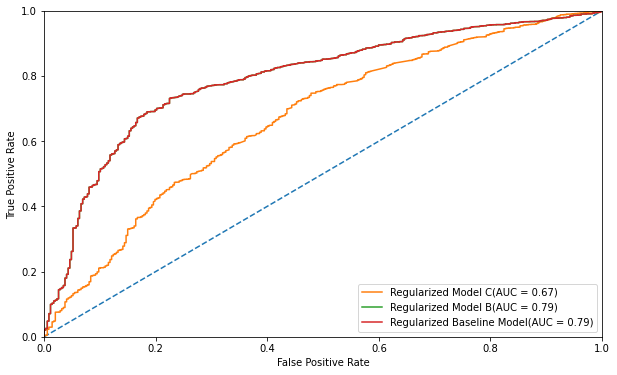

In [ ]:
##Create the ROC curve and compare with Q/D models

#ROC curve for regularized model
fprLR3, tprLR3, threshLR3 = roc_curve(y_test, preds_three)
roc_auc_LR3= roc_auc_score(y_test, preds_three)

#Plot them all!
fig = figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprLR3, tprLR3, label='Regularized Model C(AUC = %0.2f)' % roc_auc_LR3)
plt.plot(fprLR2, tprLR2, label='Regularized Model B(AUC = %0.2f)' % roc_auc_LR2)
plt.plot(fprLR, tprLR, label='Regularized Baseline Model(AUC = %0.2f)' % roc_auc_LR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()
#fig.savefig('QvsDvsLR_ModelROC.pdf', bbox_inches='tight')

In [ ]:
ready_six_guess = ready_four.drop(columns = ['total_investment', 'early_stage_VC', 'late_stage', 'debt_financing', 'pre-seed'])
ready_six_guess

,funding_rounds,founded_month,age_first_funding,statusNumbered,Advertising,Analytics,Biotechnology,Clean Technology,Consulting,Curated Web,...,me,net,org,other,tv,uk,Q1,Q2,Q3,Q4
0,0.000000,0.454545,0.004238,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.000000,0.818182,0.000000,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.000000,0.272727,0.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0.000000,0.000000,0.243314,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,0.000000,0.000000,0.060500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,0.176471,0.000000,0.644600,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49422,0.000000,0.000000,0.324419,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49423,0.000000,0.000000,0.061377,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49425,0.235294,0.363636,0.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:


#Here's an old school way that lets us separate the X and Y later 
np.random.seed(1) #Pick X_train = dfTrain.drop(['statusNumbered', 'name', 'homepage_url', 'url_end', 'market', 'country_code', 'state_code', 'region', 'city', 'founded_at', 'first_funding_at','last_funding_at', 'founded_quarter', 'round_A', 'seed', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'product_crowdfunding', 'convertible_note', 'angel'],axis=1)a random seed
mask = np.random.rand(len(ready_six_guess)) < 0.8 #Generate an array of uniform random numbers between 0 and 1 and convert to 1 if < 0.8 (0 otherwise)

dfTrain = ready_six_guess[mask] #Training data
dfTest = ready_six_guess[~mask] #Testing data

y_train = dfTrain['statusNumbered']
X_train = dfTrain.drop(['statusNumbered'], axis = 1)
y_test = dfTest['statusNumbered']
X_test = dfTest.drop(['statusNumbered'], axis = 1)

#Train a regularized logistic regression model using grid search using liblinear solver

#Define model parameters to search over
params = {'C':[0.001,0.01,0.1,1,10,100,500,1000],'penalty':['l1', 'l2']}

#Define model
model = LogisticRegression(solver='liblinear', max_iter = 10000)

#Define gridsearch - how many CVs (10) and what your scoring method will be (AUC) 
clf = GridSearchCV(model,params, cv=10,scoring='roc_auc')

#Run the gridsearch
clf.fit(X_train,y_train)

#Print results
#Use the best model to make predictions
preds = clf.best_estimator_.predict_proba(X_test).T[1]

preds

array([0.97606406, 0.9332264 , 0.90444564, ..., 0.98427635, 0.99388829,
       0.99469942])

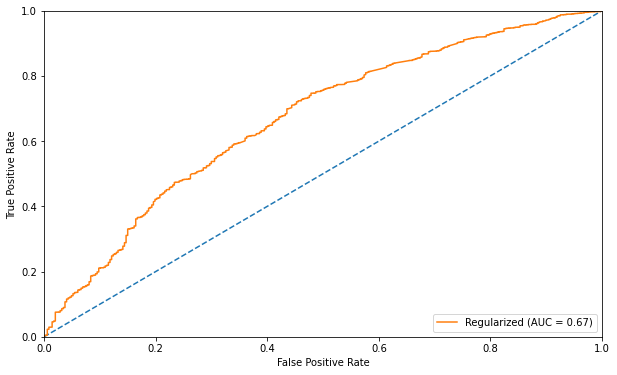

In [ ]:
#Create the ROC curve and compare with Q/D models

#ROC curve for regularized model
fprLR, tprLR, threshLR = roc_curve(y_test, preds)
roc_auc_LR= roc_auc_score(y_test, preds)

#Plot them all!
fig = figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprLR, tprLR, label='Regularized (AUC = %0.2f)' % roc_auc_LR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()

In [ ]:
ready_seven = ready_four.drop(columns = ['funding_rounds'])
ready_seven

,founded_month,debt_financing,age_first_funding,total_investment,early_stage_VC,pre-seed,late_stage,statusNumbered,Advertising,Analytics,...,me,net,org,other,tv,uk,Q1,Q2,Q3,Q4
0,0.454545,0.000000,0.004238,0.000307,0.007778,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.818182,0.000000,0.000000,0.000007,0.000178,0.000000,0.000000,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.272727,0.000000,0.000000,0.000263,0.006667,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0.000000,0.000000,0.243314,0.000000,0.000000,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,1,0,0,0
10,0.000000,0.000000,0.060500,0.000007,0.000178,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,0.000000,0.000000,0.644600,0.006013,0.000000,0.000000,0.005106,1,0,0,...,0,0,0,0,0,0,1,0,0,0
49422,0.000000,0.000000,0.324419,0.000471,0.011940,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,1,0,0,0
49423,0.000000,0.000000,0.061377,0.000056,0.001422,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,1,0,0,0
49425,0.363636,0.000000,0.000000,0.000017,0.000318,0.000359,0.000000,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:


#Here's an old school way that lets us separate the X and Y later 
np.random.seed(1) #Pick X_train = dfTrain.drop(['statusNumbered', 'name', 'homepage_url', 'url_end', 'market', 'country_code', 'state_code', 'region', 'city', 'founded_at', 'first_funding_at','last_funding_at', 'founded_quarter', 'round_A', 'seed', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'product_crowdfunding', 'convertible_note', 'angel'],axis=1)a random seed
mask = np.random.rand(len(ready_seven)) < 0.8 #Generate an array of uniform random numbers between 0 and 1 and convert to 1 if < 0.8 (0 otherwise)

dfTrain = ready_seven[mask] #Training data
dfTest = ready_seven[~mask] #Testing data

y_train = dfTrain['statusNumbered']
X_train = dfTrain.drop(['statusNumbered'], axis = 1)
y_test = dfTest['statusNumbered']
X_test = dfTest.drop(['statusNumbered'], axis = 1)

#Train a regularized logistic regression model using grid search using liblinear solver

#Define model parameters to search over
params = {'C':[0.001,0.01,0.1,1,10,100,500,1000],'penalty':['l1', 'l2']}

#Define model
model = LogisticRegression(solver='liblinear', max_iter = 10000)

#Define gridsearch - how many CVs (10) and what your scoring method will be (AUC) 
clf = GridSearchCV(model,params, cv=10,scoring='roc_auc')

#Run the gridsearch
clf.fit(X_train,y_train)

#Print results
#Use the best model to make predictions
preds = clf.best_estimator_.predict_proba(X_test).T[1]

preds

array([0.97698936, 0.94303327, 0.88947041, ..., 0.95462016, 0.99984374,
       0.99256964])

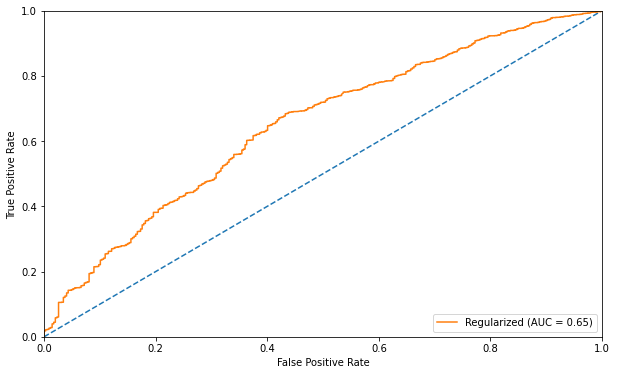

In [ ]:
#Create the ROC curve and compare with Q/D models

#ROC curve for regularized model
fprLR, tprLR, threshLR = roc_curve(y_test, preds)
roc_auc_LR= roc_auc_score(y_test, preds)

#Plot them all!
fig = figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprLR, tprLR, label='Regularized (AUC = %0.2f)' % roc_auc_LR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()

In [ ]:

total_successful_companies_bymarket = df1.groupby(['market']).sum()['statusNumbered']
total_companies_by_market = df1.groupby(['market']).count()['statusNumbered']
rate = total_successful_companies_bymarket/total_companies_by_market
rate


market
 Advertising             0.932203
 Analytics               0.984881
 Biotechnology           0.966258
 Clean Technology        0.945568
 Consulting              0.933333
 Curated Web             0.862832
 E-Commerce              0.943508
 Education               0.972325
 Enterprise Software     0.964401
 Finance                 0.954296
 Games                   0.900794
 Hardware + Software     0.943536
 Health Care             0.965654
 Health and Wellness     0.975379
 Manufacturing           0.976945
 Mobile                  0.919343
 Other                   0.950150
 Security                0.949555
 Semiconductors          0.906475
 Social Media            0.882255
 Software                0.946261
Name: statusNumbered, dtype: float64